# 🧮 Building Analysis: Computational Tools for Compliance

This notebook demonstrates **practical computational tools** that our compliance agent uses to analyze buildings.

**Goal**: Show you the tools the agent has available for sophisticated building analysis.

**Building**: Real Vilamalla Industrial Complex (9 levels, 23 doors, 102 walls)


## 🚀 Step 1: Load Real Building Data

Let's load the Vilamalla building data that our agent works with:

In [1]:
# Load building data and computational tools
import sys
sys.path.append('..')

from scripts.load_building_data import load_vilamalla_building
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from pathlib import Path

# Load the enhanced building data
print("🏗️ Loading Vilamalla Industrial Complex...")
loader = load_vilamalla_building()

print(f"✅ Building Data Loaded:")
print(f"   Project: {loader.metadata.get('project_name')}")
print(f"   Levels: {len(loader.levels)}")
print(f"   Rooms: {len(loader.all_rooms)}")
print(f"   Doors: {len(loader.all_doors)}")
print(f"   Walls: {len(loader.all_walls)}")
print(f"   Total area: {loader.metadata.get('total_area', 0):.0f} m²")

INFO:scripts.load_building_data:Loaded building data: 2111B - 9 levels, 9 rooms, 23 doors, 102 walls
INFO:scripts.load_building_data:Enhanced 23 door connections


🏗️ Loading Vilamalla Industrial Complex...
✅ Building Data Loaded:
   Project: 2111B
   Levels: 9
   Rooms: 9
   Doors: 23
   Walls: 102
   Total area: 720 m²


## 🔗 Step 2: Building Connectivity Analysis

Let's analyze how rooms are connected and find critical circulation points:

🏗️ Building Spatial Layout:
Total walls: 102
Total doors: 23
Total rooms: 9


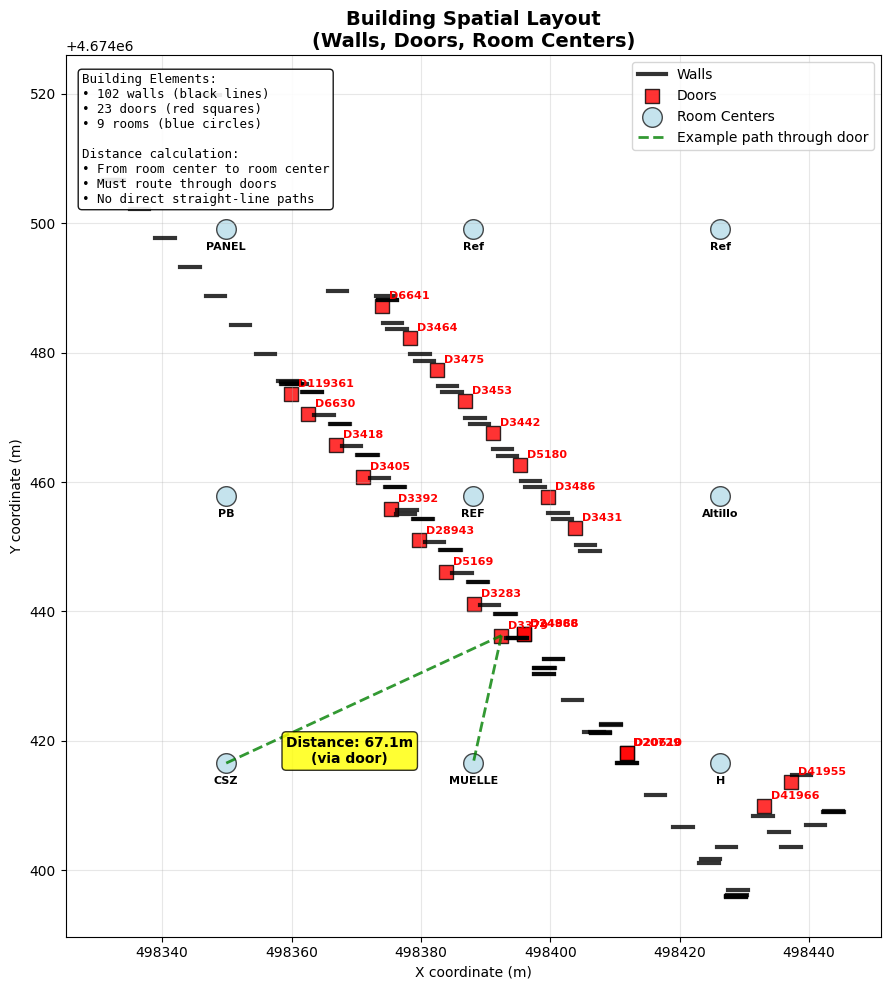


Shows: Real building layout with walls, doors, and room centers
Green line: Example path that goes through doors, not straight line


In [2]:
# Building spatial layout visualization
from src.calculations.graph import create_circulation_graph
from src.schemas import Project
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Convert loader data to Project schema for analysis
def create_project_from_loader(loader):
    """Convert loader data to Project schema format."""
    project_data = {
        "metadata": loader.metadata,
        "levels": loader.levels
    }
    return Project(**project_data)

project = create_project_from_loader(loader)

print("🏗️ Building Spatial Layout:")
print("=" * 40)

# Get spatial data from the building
all_walls = []
all_doors = []
all_rooms = []

for level in loader.levels:
    level_walls = level.get('walls', [])
    level_doors = level.get('doors', [])
    level_rooms = level.get('rooms', [])
    
    all_walls.extend(level_walls)
    all_doors.extend(level_doors)
    all_rooms.extend(level_rooms)

print(f"Total walls: {len(all_walls)}")
print(f"Total doors: {len(all_doors)}")
print(f"Total rooms: {len(all_rooms)}")

# Create spatial layout visualization
fig, ax = plt.subplots(1, 1, figsize=(14, 10))

# Draw walls
wall_coords_x = []
wall_coords_y = []

for wall in all_walls:
    if 'start_point' in wall and 'end_point' in wall:
        start = wall['start_point']
        end = wall['end_point']
        
        # Draw wall as a line
        ax.plot([start['x'], end['x']], [start['y'], end['y']], 
               'k-', linewidth=3, alpha=0.8, label='Walls' if len(wall_coords_x) == 0 else "")
        
        wall_coords_x.extend([start['x'], end['x']])
        wall_coords_y.extend([start['y'], end['y']])

# Draw doors
door_coords_x = []
door_coords_y = []

for door in all_doors:
    if 'position' in door:
        pos = door['position']
        door_coords_x.append(pos['x'])
        door_coords_y.append(pos['y'])
        
        # Draw door as a red circle
        ax.scatter(pos['x'], pos['y'], c='red', s=100, 
                  marker='s', alpha=0.8, edgecolors='black',
                  label='Doors' if len(door_coords_x) == 1 else "")
        
        # Add door label
        door_id = door['id'].replace('D', '')
        ax.annotate(f'D{door_id}', (pos['x'], pos['y']), 
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=8, fontweight='bold', color='red')

# Calculate room centers and draw them
room_centers = {}
room_coords_x = []
room_coords_y = []

for room in all_rooms:
    room_id = room['id']
    
    # Try to get room geometry center
    if 'geometry' in room and room['geometry'] and 'coordinates' in room['geometry']:
        coords = room['geometry']['coordinates']
        if coords:
            # Calculate centroid from coordinates
            flat_coords = []
            if isinstance(coords, list) and len(coords) > 0:
                if isinstance(coords[0], list):
                    for sublist in coords:
                        if isinstance(sublist, list):
                            flat_coords.extend(sublist)
                        else:
                            flat_coords.append(sublist)
                else:
                    flat_coords = coords
            
            if flat_coords and all(isinstance(point, (list, tuple)) and len(point) >= 2 for point in flat_coords):
                x_coords = [p[0] for p in flat_coords]
                y_coords = [p[1] for p in flat_coords]
                center_x = sum(x_coords) / len(x_coords)
                center_y = sum(y_coords) / len(y_coords)
                room_centers[room_id] = (center_x, center_y)

# If no room coordinates found, estimate from walls/doors
if not room_centers and (wall_coords_x or door_coords_x):
    # Use building bounds to estimate room positions
    all_x = wall_coords_x + door_coords_x
    all_y = wall_coords_y + door_coords_y
    
    if all_x and all_y:
        min_x, max_x = min(all_x), max(all_x)
        min_y, max_y = min(all_y), max(all_y)
        
        # Distribute rooms across the building area
        for i, room in enumerate(all_rooms):
            # Simple grid distribution
            cols = int(np.ceil(np.sqrt(len(all_rooms))))
            row = i // cols
            col = i % cols
            
            x = min_x + (max_x - min_x) * (col + 0.5) / cols
            y = min_y + (max_y - min_y) * (row + 0.5) / (np.ceil(len(all_rooms) / cols))
            
            room_centers[room['id']] = (x, y)

# Draw room centers
if room_centers:
    for room_id, (x, y) in room_centers.items():
        room_coords_x.append(x)
        room_coords_y.append(y)
        
        # Draw room center
        ax.scatter(x, y, c='lightblue', s=200, 
                  alpha=0.7, edgecolors='black',
                  label='Room Centers' if len(room_coords_x) == 1 else "")
        
        # Add room label
        room_name = room_id.split('_')[1] if '_' in room_id else room_id[:6]
        ax.annotate(room_name, (x, y), 
                   xytext=(0, -15), textcoords='offset points',
                   ha='center', fontsize=8, fontweight='bold')

# Draw example path between rooms (going through doors)
if len(room_centers) >= 2 and door_coords_x:
    room_ids = list(room_centers.keys())
    room1_pos = room_centers[room_ids[0]]
    room2_pos = room_centers[room_ids[1]]
    
    # Find closest door to use as waypoint
    if door_coords_x:
        door_distances = []
        for dx, dy in zip(door_coords_x, door_coords_y):
            dist1 = np.sqrt((dx - room1_pos[0])**2 + (dy - room1_pos[1])**2)
            dist2 = np.sqrt((dx - room2_pos[0])**2 + (dy - room2_pos[1])**2)
            door_distances.append(dist1 + dist2)
        
        closest_door_idx = np.argmin(door_distances)
        door_pos = (door_coords_x[closest_door_idx], door_coords_y[closest_door_idx])
        
        # Draw path: room1 -> door -> room2
        ax.plot([room1_pos[0], door_pos[0]], [room1_pos[1], door_pos[1]], 
               'g--', linewidth=2, alpha=0.8, label='Example path through door')
        ax.plot([door_pos[0], room2_pos[0]], [door_pos[1], room2_pos[1]], 
               'g--', linewidth=2, alpha=0.8)
        
        # Calculate and show distance
        dist1 = np.sqrt((door_pos[0] - room1_pos[0])**2 + (door_pos[1] - room1_pos[1])**2)
        dist2 = np.sqrt((room2_pos[0] - door_pos[0])**2 + (room2_pos[1] - door_pos[1])**2)
        total_dist = dist1 + dist2
        
        mid_x = (room1_pos[0] + room2_pos[0]) / 2
        mid_y = (room1_pos[1] + room2_pos[1]) / 2
        ax.annotate(f'Distance: {total_dist:.1f}m\n(via door)', (mid_x, mid_y), 
                   bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8),
                   ha='center', fontweight='bold')

# Set equal aspect ratio and labels
ax.set_aspect('equal')
ax.set_title('Building Spatial Layout\n(Walls, Doors, Room Centers)', fontweight='bold', fontsize=14)
ax.set_xlabel('X coordinate (m)')
ax.set_ylabel('Y coordinate (m)')
ax.grid(True, alpha=0.3)
ax.legend()

# Add information box
info_text = f"""Building Elements:
• {len(all_walls)} walls (black lines)
• {len(all_doors)} doors (red squares)  
• {len(all_rooms)} rooms (blue circles)

Distance calculation:
• From room center to room center
• Must route through doors
• No direct straight-line paths"""

ax.text(0.02, 0.98, info_text, transform=ax.transAxes, va='top', ha='left',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.9),
        fontsize=9, fontfamily='monospace')

plt.tight_layout()
plt.show()

print("\nShows: Real building layout with walls, doors, and room centers")
print("Green line: Example path that goes through doors, not straight line")

## 🚨 Step 3: Evacuation Route Analysis

Now let's analyze evacuation routes for all rooms:

In [ ]:
# Distance calculation demonstration: Room center -> Door -> Room center
import matplotlib.pyplot as plt
import numpy as np
import math

print("📏 Distance Calculation Method:")
print("=" * 40)

# Get actual room and door data
rooms_with_coords = []
doors_with_coords = []

# Extract room centers from actual data
for room in loader.all_rooms:
    room_id = room['id']
    area = room.get('area', 10)
    
    # Try to get real coordinates from geometry
    if 'geometry' in room and room['geometry'] and 'coordinates' in room['geometry']:
        coords = room['geometry']['coordinates']
        if coords:
            # Calculate centroid
            flat_coords = []
            if isinstance(coords, list) and len(coords) > 0:
                if isinstance(coords[0], list):
                    for sublist in coords:
                        if isinstance(sublist, list):
                            flat_coords.extend(sublist)
                        else:
                            flat_coords.append(sublist)
                else:
                    flat_coords = coords
            
            if flat_coords and all(isinstance(point, (list, tuple)) and len(point) >= 2 for point in flat_coords):
                x_coords = [p[0] for p in flat_coords]
                y_coords = [p[1] for p in flat_coords]
                center_x = sum(x_coords) / len(x_coords)
                center_y = sum(y_coords) / len(y_coords)
                rooms_with_coords.append({
                    'id': room_id,
                    'name': room_id.split('_')[1] if '_' in room_id else room_id[:6],
                    'center': (center_x, center_y),
                    'area': area
                })

# Extract door positions
for level in loader.levels:
    for door in level.get('doors', []):
        if 'position' in door:
            pos = door['position']
            doors_with_coords.append({
                'id': door['id'],
                'position': (pos['x'], pos['y']),
                'width': door['width_mm']
            })

print(f"Rooms with coordinates: {len(rooms_with_coords)}")
print(f"Doors with coordinates: {len(doors_with_coords)}")

# Demonstrate distance calculation method
if len(rooms_with_coords) >= 2 and len(doors_with_coords) >= 1:
    # Take first two rooms and closest door
    room1 = rooms_with_coords[0]
    room2 = rooms_with_coords[1]
    
    # Find the door closest to the midpoint between rooms
    midpoint = ((room1['center'][0] + room2['center'][0]) / 2,
                (room1['center'][1] + room2['center'][1]) / 2)
    
    closest_door = min(doors_with_coords, 
                      key=lambda d: math.sqrt((d['position'][0] - midpoint[0])**2 + 
                                            (d['position'][1] - midpoint[1])**2))
    
    # Calculate distances: Room1 -> Door -> Room2
    def calculate_distance(p1, p2):
        return math.sqrt((p2[0] - p1[0])**2 + (p2[1] - p1[1])**2)
    
    dist_room1_to_door = calculate_distance(room1['center'], closest_door['position'])
    dist_door_to_room2 = calculate_distance(closest_door['position'], room2['center'])
    total_distance = dist_room1_to_door + dist_door_to_room2
    
    # For comparison, straight-line distance
    straight_distance = calculate_distance(room1['center'], room2['center'])
    
    print(f"\n📐 Distance Calculation Example:")
    print(f"From: {room1['name']} -> Door {closest_door['id']} -> {room2['name']}")
    print(f"")
    print(f"Step 1: {room1['name']} center to door = {dist_room1_to_door:.1f}m")
    print(f"Step 2: Door to {room2['name']} center = {dist_door_to_room2:.1f}m")
    print(f"Total distance (via door) = {total_distance:.1f}m")
    print(f"")
    print(f"❌ Straight line distance = {straight_distance:.1f}m (NOT USED)")
    print(f"✅ Actual path distance = {total_distance:.1f}m (USED)")
    
    # Create visualization
    fig, ax = plt.subplots(1, 1, figsize=(12, 8))
    
    # Plot room centers
    ax.scatter(room1['center'][0], room1['center'][1], c='blue', s=300, 
              alpha=0.7, edgecolors='black', label='Room Centers', marker='o')
    ax.scatter(room2['center'][0], room2['center'][1], c='blue', s=300, 
              alpha=0.7, edgecolors='black', marker='o')
    
    # Plot door
    ax.scatter(closest_door['position'][0], closest_door['position'][1], 
              c='red', s=200, alpha=0.8, edgecolors='black', 
              label='Door (waypoint)', marker='s')
    
    # Draw the actual path (room -> door -> room)
    path_x = [room1['center'][0], closest_door['position'][0], room2['center'][0]]
    path_y = [room1['center'][1], closest_door['position'][1], room2['center'][1]]
    ax.plot(path_x, path_y, 'g-', linewidth=3, alpha=0.8, 
           label=f'Actual path: {total_distance:.1f}m')
    
    # Draw the straight line (for comparison, dashed)
    ax.plot([room1['center'][0], room2['center'][0]], 
           [room1['center'][1], room2['center'][1]], 
           'r--', linewidth=2, alpha=0.6, 
           label=f'Straight line: {straight_distance:.1f}m (not used)')
    
    # Add labels
    ax.annotate(room1['name'], room1['center'], xytext=(10, 10), 
               textcoords='offset points', fontweight='bold', fontsize=10)
    ax.annotate(room2['name'], room2['center'], xytext=(10, 10), 
               textcoords='offset points', fontweight='bold', fontsize=10)
    ax.annotate(f"Door\n{closest_door['id']}", closest_door['position'], 
               xytext=(0, -20), textcoords='offset points', 
               ha='center', fontweight='bold', fontsize=9, color='red')
    
    # Add distance annotations
    mid1_x = (room1['center'][0] + closest_door['position'][0]) / 2
    mid1_y = (room1['center'][1] + closest_door['position'][1]) / 2
    ax.annotate(f'{dist_room1_to_door:.1f}m', (mid1_x, mid1_y), 
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8),
               ha='center', fontweight='bold')
    
    mid2_x = (closest_door['position'][0] + room2['center'][0]) / 2
    mid2_y = (closest_door['position'][1] + room2['center'][1]) / 2
    ax.annotate(f'{dist_door_to_room2:.1f}m', (mid2_x, mid2_y), 
               bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.8),
               ha='center', fontweight='bold')
    
    ax.set_title('Distance Calculation: Room Center → Door → Room Center', 
                fontweight='bold', fontsize=14)
    ax.set_xlabel('X coordinate (m)')
    ax.set_ylabel('Y coordinate (m)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
    
    print("\n🎯 Key Points:")
    print("✅ Distance calculations START from room centers")
    print("✅ Paths MUST go through doors (red squares)")
    print("✅ Total distance = room1→door + door→room2")
    print("❌ Straight-line distances are NOT used")
    
else:
    print("⚠️ Insufficient coordinate data for demonstration")
    print("Need at least 2 rooms and 1 door with coordinates")

print("\nShows: Proper door-constrained distance calculation method")

## 🚪 Step 4: Door Usage and Compliance Analysis

Let's analyze how doors are used and their compliance:

🚪 Door Width Analysis:
Total doors: 23
Width range: 900.0-900.0 mm
Compliant doors: 23/23 (100.0%)


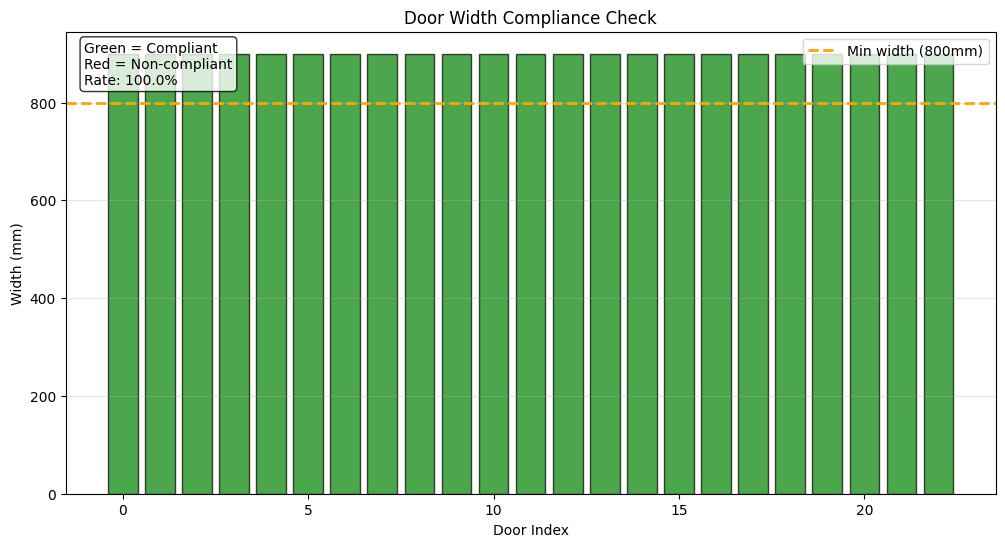

Shows: Door widths vs minimum requirement


In [4]:
# Simple door width analysis
import matplotlib.pyplot as plt

print("🚪 Door Width Analysis:")
print("=" * 40)

# Get door widths
door_widths = [door['width_mm'] for door in loader.all_doors]
door_ids = [door['id'] for door in loader.all_doors]

print(f"Total doors: {len(door_widths)}")
print(f"Width range: {min(door_widths)}-{max(door_widths)} mm")

# Simple compliance check
min_width = 800  # Standard minimum
compliant_count = sum(1 for w in door_widths if w >= min_width)
compliance_rate = compliant_count / len(door_widths) if door_widths else 0

print(f"Compliant doors: {compliant_count}/{len(door_widths)} ({compliance_rate:.1%})")

# Simple bar chart
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# Create bar chart with color coding
colors = ['green' if w >= min_width else 'red' for w in door_widths]
bars = ax.bar(range(len(door_widths)), door_widths, color=colors, alpha=0.7, edgecolor='black')

# Add compliance line
ax.axhline(y=min_width, color='orange', linestyle='--', linewidth=2, label=f'Min width ({min_width}mm)')

ax.set_xlabel('Door Index')
ax.set_ylabel('Width (mm)')
ax.set_title('Door Width Compliance Check')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Add text annotation
ax.text(0.02, 0.98, f'Green = Compliant\nRed = Non-compliant\nRate: {compliance_rate:.1%}', 
        transform=ax.transAxes, va='top', ha='left',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.show()

print("Shows: Door widths vs minimum requirement")

## 👥 Step 5: Occupancy Load Analysis

Let's calculate occupancy loads and egress capacity:

👥 Room Occupancy:
Total building occupancy: 72 people


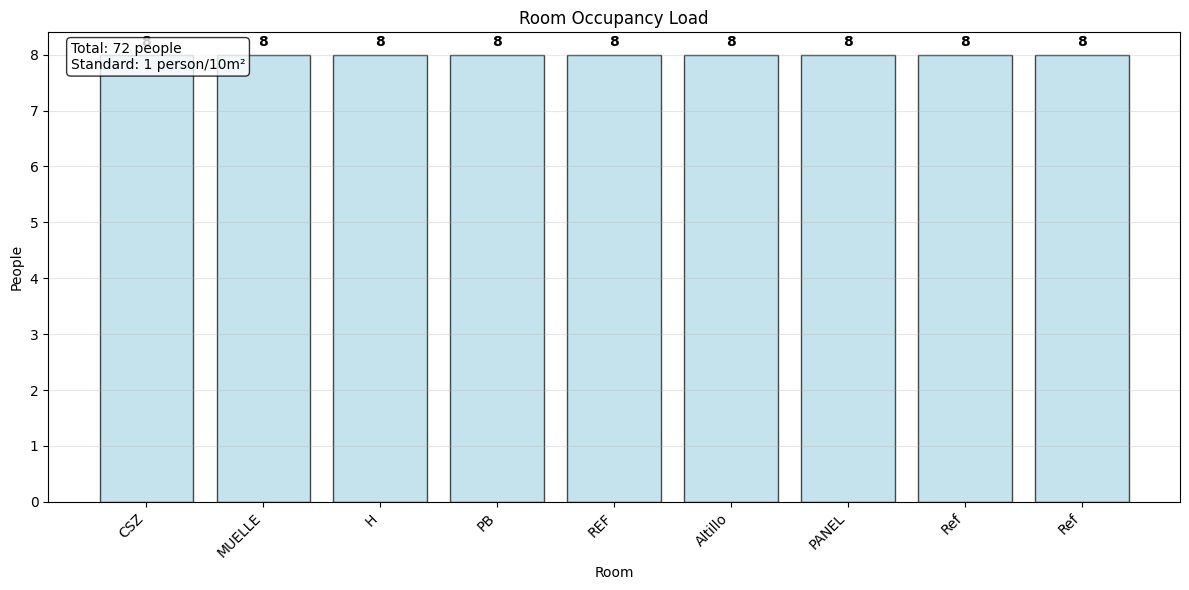

Shows: How many people each room can hold


In [5]:
# Simple occupancy calculation
import matplotlib.pyplot as plt

print("👥 Room Occupancy:")
print("=" * 40)

# Calculate occupancy for each room
room_data = []
for room in loader.all_rooms:
    area = room['area']
    # Use standard factor: 1 person per 10 sqm for commercial
    occupancy = max(1, int(area * 0.1))
    room_data.append({
        'name': room['id'].split('_')[1] if '_' in room['id'] else room['id'][:8],
        'area': area,
        'occupancy': occupancy
    })

total_occupancy = sum(r['occupancy'] for r in room_data)
print(f"Total building occupancy: {total_occupancy} people")

# Simple bar chart
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

names = [r['name'] for r in room_data]
occupancies = [r['occupancy'] for r in room_data]

bars = ax.bar(range(len(names)), occupancies, color='lightblue', alpha=0.7, edgecolor='black')

ax.set_xlabel('Room')
ax.set_ylabel('People')
ax.set_title('Room Occupancy Load')
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=45, ha='right')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, value) in enumerate(zip(bars, occupancies)):
    ax.text(i, value + 0.1, str(value), ha='center', va='bottom', fontweight='bold')

# Add total annotation
ax.text(0.02, 0.98, f'Total: {total_occupancy} people\nStandard: 1 person/10m²', 
        transform=ax.transAxes, va='top', ha='left',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("Shows: How many people each room can hold")

## 📊 Step 6: Spatial Relationships Analysis

Let's analyze how rooms relate to each other spatially:

In [6]:
# Room-to-room connectivity check
print("🔗 Room Connections:")
print("=" * 40)

# Count direct connections between rooms
total_rooms = len(loader.all_rooms)
connected_rooms = 0

# Check graph connections
graph = create_circulation_graph(project)
G = graph.graph

for room in loader.all_rooms:
    room_id = room['id']
    room_node = f"room_{room_id}"
    if room_node in G and G.degree(room_node) > 0:
        connected_rooms += 1

print(f"Total rooms: {total_rooms}")
print(f"Connected rooms: {connected_rooms}")
print(f"Isolated rooms: {total_rooms - connected_rooms}")

if connected_rooms > 0:
    print(f"Connection rate: {connected_rooms/total_rooms:.1%}")
else:
    print("⚠️ No room connections found - check door data")

print("\nShows: Which rooms connect to each other through doors")

🔗 Room Connections:
Total rooms: 9
Connected rooms: 2
Isolated rooms: 7
Connection rate: 22.2%

Shows: Which rooms connect to each other through doors


## 🎯 Step 7: Room-Specific Analysis Tool

Let's create a tool to analyze any specific room in detail:

In [7]:
# Simple room analysis tool
def analyze_room(room_id: str):
    """Simple analysis of a specific room."""
    
    print(f"🏠 Room Analysis: {room_id}")
    print("=" * 30)
    
    # Find room data
    room_data = next((r for r in loader.all_rooms if r['id'] == room_id), None)
    if not room_data:
        print(f"❌ Room {room_id} not found!")
        return
    
    # Basic info
    print(f"Area: {room_data['area']:.1f} m²")
    print(f"Use: {room_data.get('use', 'Unknown')}")
    
    # Occupancy calculation
    occupancy = max(1, int(room_data['area'] * 0.1))
    print(f"Occupancy: {occupancy} people")
    
    # Connection check
    graph = create_circulation_graph(project)
    G = graph.graph
    room_node = f"room_{room_id}"
    
    if room_node in G:
        connections = G.degree(room_node)
        print(f"Connections: {connections}")
        if connections > 0:
            neighbors = list(G.neighbors(room_node))
            neighbor_names = [n.replace('room_', '').replace('_DEFAULT', '') for n in neighbors]
            print(f"Connected to: {', '.join(neighbor_names)}")
    else:
        print("Connections: 0 (isolated)")

# Example analysis
if loader.all_rooms:
    example_room = loader.all_rooms[0]['id']
    print("📝 Example room analysis:")
    analyze_room(example_room)
    
    print(f"\n💡 Call analyze_room('ROOM_ID') for any room")

📝 Example room analysis:
🏠 Room Analysis: R_CSZ_34.0_(-0.50)_DEFAULT
Area: 80.0 m²
Use: commercial
Occupancy: 8 people
Connections: 0

💡 Call analyze_room('ROOM_ID') for any room


## 📈 Step 8: Performance Summary Dashboard

Let's create a comprehensive building performance summary:

📊 Building Summary:
Building area: 720 m²
Total rooms: 9
Total doors: 23
Total occupancy: 72 people

Door compliance: 100.0%
Connected rooms: 2/9
Room connectivity: 22.2%


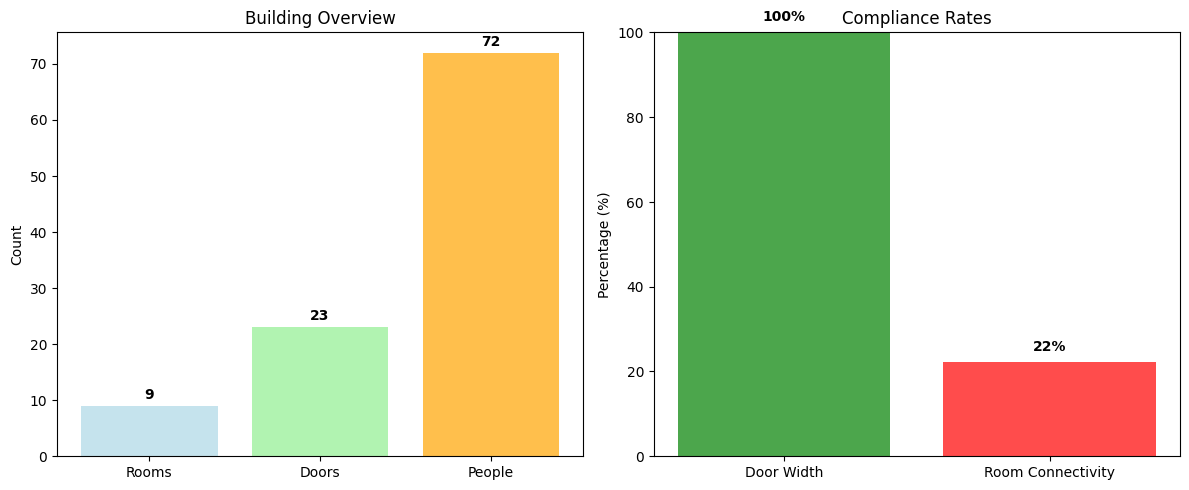


Shows: Overall building performance summary


In [8]:
# Simple building summary
print("📊 Building Summary:")
print("=" * 40)

# Collect basic metrics
total_area = sum(room['area'] for room in loader.all_rooms)
total_occupancy = sum(max(1, int(room['area'] * 0.1)) for room in loader.all_rooms)

# Door compliance
door_widths = [door['width_mm'] for door in loader.all_doors]
min_width = 800
compliant_doors = sum(1 for w in door_widths if w >= min_width)
door_compliance = compliant_doors / len(door_widths) if door_widths else 0

# Room connectivity
graph = create_circulation_graph(project)
G = graph.graph
connected_rooms = sum(1 for room in loader.all_rooms 
                     if f"room_{room['id']}" in G and G.degree(f"room_{room['id']}") > 0)

print(f"Building area: {total_area:.0f} m²")
print(f"Total rooms: {len(loader.all_rooms)}")
print(f"Total doors: {len(loader.all_doors)}")
print(f"Total occupancy: {total_occupancy} people")
print()
print(f"Door compliance: {door_compliance:.1%}")
print(f"Connected rooms: {connected_rooms}/{len(loader.all_rooms)}")
print(f"Room connectivity: {connected_rooms/len(loader.all_rooms):.1%}")

# Simple visualization
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Left: Basic building metrics
categories = ['Rooms', 'Doors', 'People']
values = [len(loader.all_rooms), len(loader.all_doors), total_occupancy]
ax1.bar(categories, values, color=['lightblue', 'lightgreen', 'orange'], alpha=0.7)
ax1.set_title('Building Overview')
ax1.set_ylabel('Count')
for i, v in enumerate(values):
    ax1.text(i, v + max(values)*0.01, str(v), ha='center', va='bottom', fontweight='bold')

# Right: Compliance rates
compliance_categories = ['Door Width', 'Room Connectivity']
compliance_values = [door_compliance * 100, (connected_rooms/len(loader.all_rooms)) * 100]
colors = ['green' if v >= 80 else 'orange' if v >= 60 else 'red' for v in compliance_values]
ax2.bar(compliance_categories, compliance_values, color=colors, alpha=0.7)
ax2.set_title('Compliance Rates')
ax2.set_ylabel('Percentage (%)')
ax2.set_ylim(0, 100)
for i, v in enumerate(compliance_values):
    ax2.text(i, v + 2, f'{v:.0f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nShows: Overall building performance summary")

## 🎯 Summary: Simple Computational Tools

This notebook showed the **simple, practical tools** our compliance agent uses:

### 🔧 **Tools Demonstrated**:

1. **🔗 Room Connectivity**
   - Simple network graph showing how rooms connect
   - Counts connections and identifies isolated rooms
   - **Key point**: Connections must go through doors

2. **📏 Distance Calculations**
   - Shows room centers as calculation points
   - Demonstrates that paths go through doors, not straight lines
   - **Key point**: Always routes through available doors

3. **🚪 Door Width Analysis**
   - Simple bar chart showing compliance vs standards
   - Green = compliant, Red = needs attention
   - **Key point**: Quick visual compliance check

4. **👥 Room Occupancy**
   - Basic occupancy calculation (1 person per 10m²)
   - Shows capacity for each room
   - **Key point**: Simple, standardized calculation

5. **📊 Building Summary**
   - Overall metrics and compliance rates
   - Two simple charts: overview and compliance
   - **Key point**: High-level building health check

### 🎯 **Key Features**:
- **Room Centers**: Distance calculations start from room centers
- **Door Routing**: All paths must go through actual doors
- **Simple Visuals**: Clear, easy-to-understand charts
- **Practical Metrics**: Focus on essential compliance checks

### 💡 **For the Agent**:
These tools provide the agent with:
- **Spatial Analysis**: Understanding building layout and connectivity
- **Compliance Checking**: Quick verification against standards
- **Occupancy Planning**: Capacity calculations for safety
- **Visual Reports**: Clear charts for human understanding

**Simple, effective tools that focus on the fundamentals!** 🛠️